# Investigating a Three Level System

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import numpy as np
from scipy.optimize import curve_fit
from scipy.constants import c, e, hbar
from qutip import *
import matplotlib.patches as mpatches

from arc import *

%matplotlib inline

C:\Users\A_SAU\Anaconda3\envs\Rydberg\lib\site-packages\qutip\__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


5


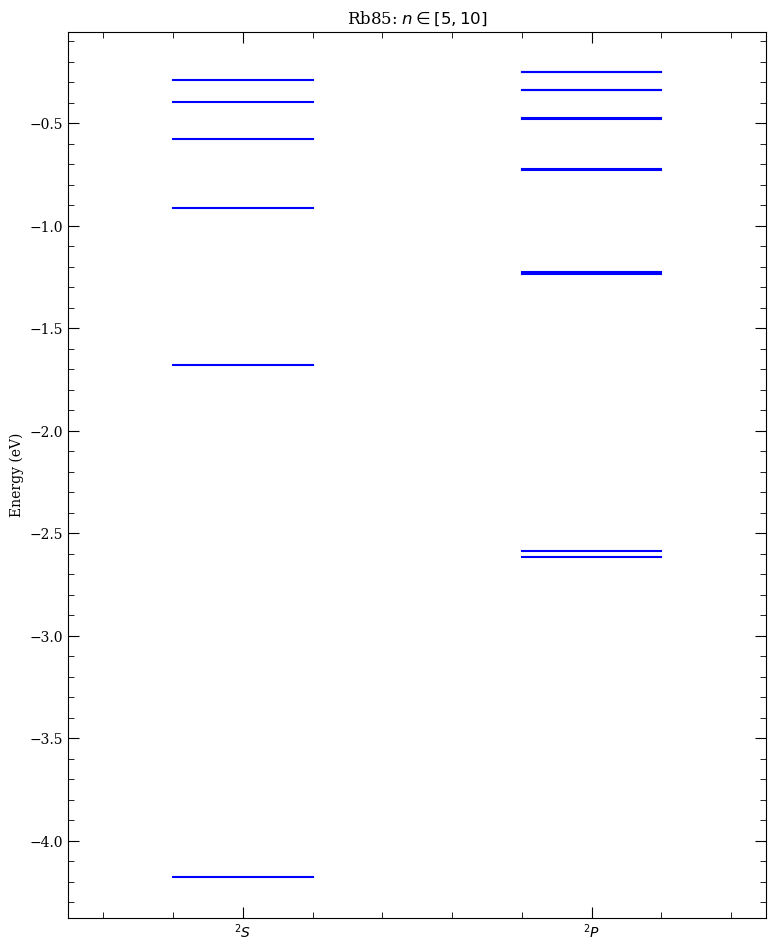

1.55959103 2369435883882498.0


In [27]:
rabi_probe = 0.001
rabi_couple = 1
detune_probe = 0
detune_couple = 0
gamma_b = 0.05
gamma_c = 0.001

atom = Rubidium(preferQuantumDefects =False)
level = atom.getEnergy(atom.groundStateN,1,0.5)-atom.getEnergy(atom.groundStateN,0,0.5)
print(atom.groundStateN)

calc = LevelPlot(atom)
calc.makeLevels(5,10, 0,1)
calc.drawLevels()
calc.showPlot()

omega_eg = level*e/hbar

print(level, omega_eg)

In [28]:
def expo(x,A,b):
    return A*np.exp(x*b)

## Introduction
We will inverstigate the Three level system and phenomena such as *slow light* and *electromagnetically induced transparency*. Theres three different ways to have a three level system: (i) ladder, (ii)
 lambda, (iii) vee.
 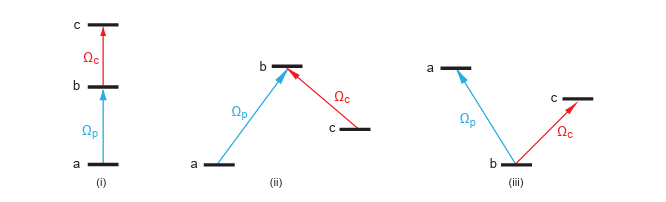

We will have a weak probe beam $\Omega_p$ and strong coupling beam $\Omega_c$.)

## Hamiltonian
The hamiltonian can be described as [1] :


$$
H = \frac{\hbar}{2}
\begin{pmatrix}
0 & \Omega_p & 0\\
\Omega_p & -2\Delta_p & \Omega_c\\
0 & \Omega_c & -2(\Delta_p-\Delta_c)
\end{pmatrix}$$

In [29]:
H = 0.5*Qobj(np.array([[0,rabi_probe,0],[rabi_probe,-2*detune_probe,rabi_couple],[0,rabi_couple,-2*(detune_probe-detune_couple)]]))
psi0 = (basis(3,0)*2+basis(3, 1)).unit()
c_ops = [np.sqrt(gamma_b)*(qutip.three_level_atom.three_level_ops()[3].dag()),np.sqrt(gamma_c)*qutip.three_level_atom.three_level_ops()[4].dag()]
e_ops = [np.sqrt(2)*jmat(1,'x'),np.sqrt(2)*jmat(1,'y'),2*jmat(1,'z')-1]

# a_op = Qobj(np.array([[0,np.sqrt(gamma_b),0],[np.sqrt(gamma_b),0,np.sqrt(gamma_c)],[0,np.sqrt(gamma_c),0]]))

times = np.linspace(0, 10, 1500)
result_me = mesolve(H, psi0, times, c_ops, e_ops)
# result_brme = brmesolve(H, psi0, times, [a_op], e_ops)

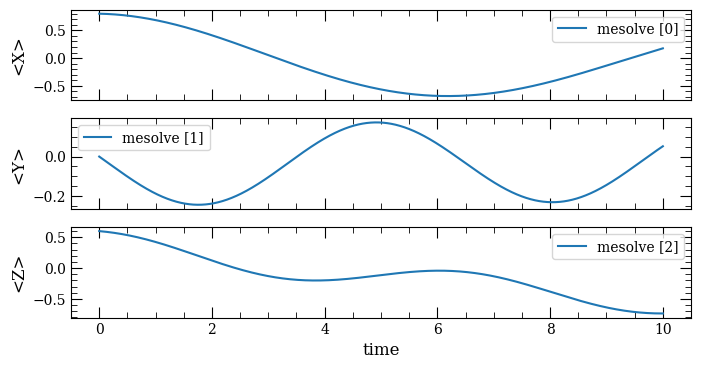

In [30]:
plot_expectation_values(
    [result_me], ylabels=["<X>", "<Y>", "<Z>"], show_legend=True
);

# Observations
Unsure why z expectation needs to be $2\times jmat -1$ as of yet, but it matches the TLS for cases where:

$\gamma_e = \Omega_p = 1$

$\gamma_e >> \Omega_p$

$\gamma_e = 0$

With Detuning introduced: oscillations appear smaller but the overall shape i.e. decay continues at a similar rate

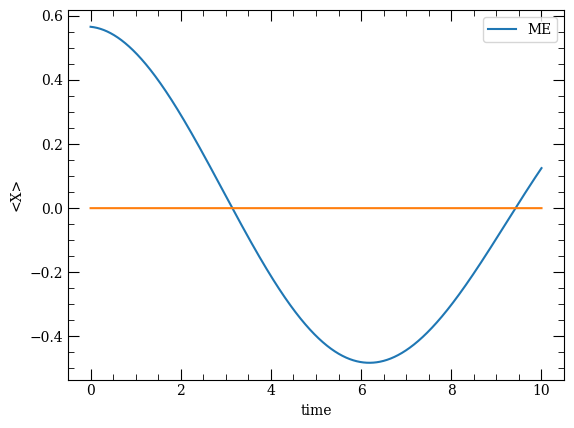

In [31]:
me_s = mesolve(H, psi0, times, c_ops, e_ops=[])
# brme_s = brmesolve(H, psi0, times, [a_op], e_ops=[])

# calculate expecation values
x_me = expect(jmat(1,'x'), me_s.states)
# x_brme = expect(jmat(1,'x'), brme_s.states)

# plot the expectation values
plt.plot(times, x_me, label="ME")
# plt.plot(times, x_brme, label="BRME")
plt.plot(times, 0*times)
plt.legend(), plt.xlabel("time"), plt.ylabel("<X>");

0.10132279558008778 exp(time*  -0.11362670708558037 )


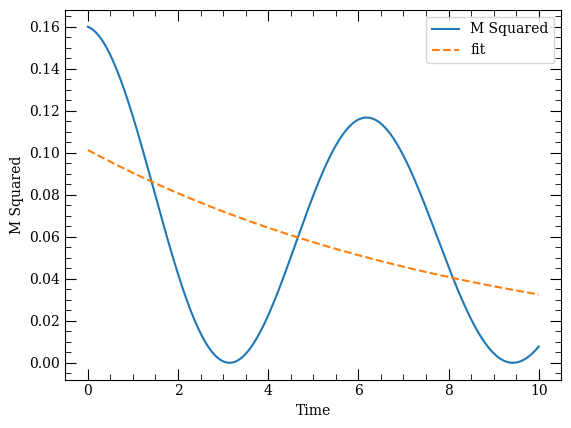

In [32]:
me_states = mesolve(H, psi0, times, c_ops, e_ops=[])
M_square = np.abs([state[0][0][1]*state[1][0][0] for state in me_states.states])

plt.plot(times, M_square, label="M Squared")
# plt.ylim(0,0.2)
A,b = curve_fit(expo,times,M_square)[0]
plt.plot(times, expo(times,A,b), label = "fit", linestyle="dashed")
plt.legend(), plt.xlabel("Time"), plt.ylabel("M Squared");
print(A,"exp(time* ",b,")")

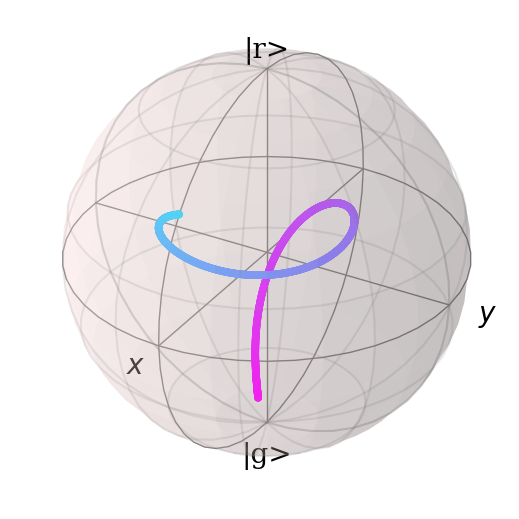

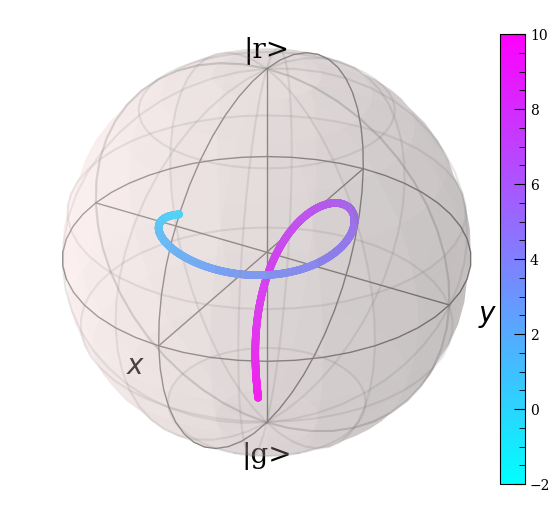

In [33]:
b = Bloch()
# normalize colors to times in tlist ##
nrm = mpl.colors.Normalize(-2, 10)
colors = cm.cool(nrm(times))

# add data points from expectation values ##
b.add_points(result_me.expect, "m")

# customize sphere properties ##
b.point_color = list(colors)
b.point_marker = ["o"]
b.point_size = [20]
b.zlabel = ['|r>', '|g>']

b.zlpos = [1.1, -1.2]
b.show()
left, bottom, width, height = [0.98, 0.05, 0.05, 0.9]
ax2 = b.fig.add_axes([left, bottom, width, height])
mpl.colorbar.ColorbarBase(ax2, cmap=cm.cool, norm=nrm, orientation="vertical");

b.fig

Bloch Spheres look off atm. Not sure if it's correct to plot them for a three level atom

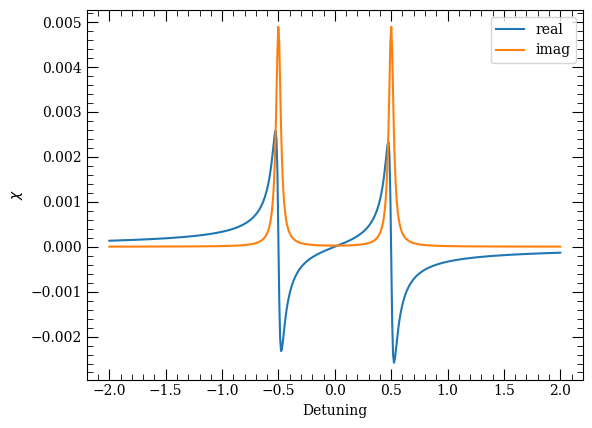

In [34]:
detuning_eg = np.linspace(-2,2,500)
psi0 = (basis(3,0)*2+basis(3, 1)).unit()
c_ops = [np.sqrt(gamma_b)*(qutip.three_level_atom.three_level_ops()[3].dag()),np.sqrt(gamma_c)*qutip.three_level_atom.three_level_ops()[4].dag()]
e_ops = [np.sqrt(2)*jmat(1,'x'),np.sqrt(2)*jmat(1,'y'),2*jmat(1,'z')-1]
real = []
imag=[]

for detune in detuning_eg:
    H = 0.5*Qobj(np.array([[0,rabi_probe,0],[rabi_probe,-2*detune,rabi_couple],[0,rabi_couple,-2*(detune-detune_couple)]]))
    result = steadystate(H, c_ops)
    real.append(result[1,0].real)
    imag.append(result[1,0].imag)
    # plt.scatter(detune,(result[1,0]).real, color = 'r', marker = '.')
    # plt.scatter(detune, (result[1,0]).imag, color = 'b', marker = '.')

real = np.array(real)
imag = np.array(imag)

plt.plot(detuning_eg, real, label = 'real')
plt.plot(detuning_eg, imag, label = 'imag')
plt.legend()
plt.xlabel('Detuning')
plt.ylabel('$\chi$')
plt.show()


# # a_op = Qobj(np.array([[0,np.sqrt(gamma_b),0],[np.sqrt(gamma_b),0,np.sqrt(gamma_c)],[0,np.sqrt(gamma_c),0]]))

# times = np.linspace(0, 10, 1500)
# result_me = mesolve(H, psi0, times, c_ops, e_ops)
# # result_brme = brmesolve(H, psi0, times, [a_op], e_ops)

Graph shows IET when $\Omega_c>\Omega_p$, $\gamma_b > \gamma_c $, and $\Delta_c = 0$

If  $\gamma_b << \Omega_p$  Very large transmission frequency

## Group Velocity

Can relate $\chi$ to the group velocity of the gas with number density $n$ by [2]:
$$
v = \frac{c}{1+\frac{1}{2}Re(\chi)+\frac{\omega_p}{2}(\frac{d Re(\chi)}{d\omega_p})}
$$

I have seen other equations for group velocity.

[3] didnt have the middle term in the denominator. This could be because it is negligible as seen in the plots below

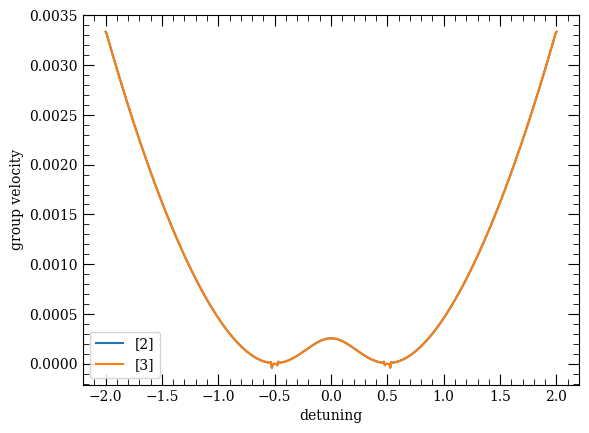

In [35]:
dchi = np.gradient(real, detuning_eg)
denom = 1+real/2+(omega_eg-detuning_eg)*dchi/2
# plt.plot(detuning_eg, denom)
plt.plot(detuning_eg, c/denom, label = '[2]')
plt.plot(detuning_eg, c/(1+(omega_eg+detuning_eg)*dchi/2), label='[3]')

plt.xlabel('detuning')
plt.ylabel('group velocity')
plt.legend()

From the dependance on $\omega_{eg}$, a larger frequency will result in slower light. This corresponds to a high energy gap between the ground |g> and excited |e> states. This corresponds to lighter atoms.

## Bibliography
[1] http://info.phys.unm.edu/~ideutsch/Classes/Phys566F13/Notes%20from%20others/Atom-Light%20Interactions.pdf

[2] https://core.ac.uk/download/pdf/294691.pdf

[3] https://arxiv.org/pdf/quant-ph/0306186.pdf

In [36]:
result_me.expect

[array([0.8       , 0.79986214, 0.79971542, ..., 0.17272499, 0.1746854 ,
        0.17664322]),
 array([ 0.        , -0.0013391 , -0.00267991, ...,  0.04955073,
         0.0508267 ,  0.05209932]),
 array([ 0.6       ,  0.59946195,  0.59891516, ..., -0.73532122,
        -0.73531348, -0.73529712])]

In [37]:
jmat(1,'z')*psi0

Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.89442719]
 [0.        ]
 [0.        ]]

In [38]:
result_me.expect

[array([0.8       , 0.79986214, 0.79971542, ..., 0.17272499, 0.1746854 ,
        0.17664322]),
 array([ 0.        , -0.0013391 , -0.00267991, ...,  0.04955073,
         0.0508267 ,  0.05209932]),
 array([ 0.6       ,  0.59946195,  0.59891516, ..., -0.73532122,
        -0.73531348, -0.73529712])]